<a href="https://colab.research.google.com/github/JSJeong-me/AJ2/blob/main/EfficientNet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%cd ..

/content


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
!cp -r ./efficientnet_keras_transfer_learning /content/drive/

cp: cannot create directory '/content/drive/efficientnet_keras_transfer_learning': Operation not supported


# How to Train EfficientNet to recognize custom classifications


Many, many props to DLogogy for publishing the orginal version of this tutorial. [How to do Transfer learning with EfficientNet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/)

We use the same training infrastructure here with preprocessing, augmentations, and data import from Roboflow.

You only need to change one line of code for your dataset import to train this classification model.

You can scale the EfficientNet model up including:

* EfficientNet-B0
* EfficientNet-B1
* EfficientNet-B2
* EfficientNet-B3

Consider reading the [Original Paper](https://arxiv.org/pdf/1905.11946.pdf)

We recommend having the [Train EfficientNet Blog Post](https://blog.roboflow.ai/how-to-train-efficientnet/) up side by side to this notebook

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)


## Import EfficientNet Dependencies



In [1]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
!pip install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.1 MB 5.0 MB/s 
     |████████████████████████████████| 112 kB 62.4 MB/s 
  Created wheel for pillow: filename=Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl size=1007415 sha256=51d93df186b07dad97d4bf8cf3f0bc674f090e901f14c4515a0c2a9daa958c13
  Stored in directory: /root/.cache/pip/wheels/ec/1e/24/dbc5e4964ea99cad93230a9013d934fb5adc322c3102f69e45
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35432 sha256=ceed61420349bcc02f0615bc4a7520b836e641d0252162d9fe40e250fd83e011
  Stored in directory: /root/.cache/pip/wheels/84/53/e6/37d90ccb3ad1a3ca98d2b17107e9fda401a7c541ea1eb6a65a
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into accou

In [ ]:
%tensorflow_version 1.x
#in case your keras version has bumped ahead you may want to try reverting to 2.3.1
!pip install q keras==2.3.1

In [1]:
import keras
keras.__version__

'2.8.0'

In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Clone **EfficinetNet** repo

Credit to [DLogogy](https://www.dlology.com/blog/transfer-learning-with-efficientnet/)

In [3]:

import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning




## Import efficientnet and Choose EfficientNet Model

In [4]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.

#Choose
#EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
# tf.random.normal

In [5]:
# loading pretrained conv base model

#define input height and width
width = 150
height = 150
input_shape = (height, width, 3)


conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

## Import Custom Dataset From Roboflow

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

After loading your dataset in by dragging and dropping, you will only need to change one line of code with the curl link to train your own custom classification model.

Before upload, make sure that your data is in the structure

folder

---class1
    
------images
  
---class2

------images
  
  ...

In [ ]:
# !curl -L "[YOUR LINK HERE]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


In [7]:
!ls -l

total 4296
drwxr-xr-x 3 root root    4096 Jul 28 03:40  efficientnet
drwxr-xr-x 2 root root    4096 Jul 28 03:35  examples
-rw-r--r-- 1 root root      27 Jul 28 03:35  __init__.py
-rw-r--r-- 1 root root  173397 Jul 28 03:35  Keras_efficientnet_transfer_learning.ipynb
-rw-r--r-- 1 root root      17 Jul 28 03:35  MANIFEST.in
drwxr-xr-x 2 root root    4096 Jul 28 03:35  misc
-rw-r--r-- 1 root root    3626 Jul 28 03:35  README.md
-rw-r--r-- 1 root root 4194304 Jul 28 03:44 'RockPaper Scissors.v1-raw-300x300.folder.zip'
-rw-r--r-- 1 root root    3700 Jul 28 03:35  setup.py


In [ ]:
!unzip ./RockPaperScissors.v1-raw-300x300.folder.zip

In [6]:
train_dir = '/content/efficientnet_keras_transfer_learning/train/'
valid_dir = '/content/efficientnet_keras_transfer_learning/valid/'
test_dir = '/content/efficientnet_keras_transfer_learning/test/'
batch_size = 4


import os
import random
def delete_all_but(split_path, number):
  images = []
  for path, subdirs, files in os.walk(split_path):
      for name in files:
          images.append(os.path.join(path, name))
  if len(images) > number:
    keep = random.sample(images, number)
    for img in images:
      if img not in keep:
        os.remove(img)
  return None


delete_all_but(train_dir, 25)
delete_all_but(valid_dir, 25)
delete_all_but(test_dir, 25)




In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')
train_generator.class_indices

Found 25 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


{'paper': 0, 'rock': 1, 'scissors': 2}

# Set up EfficientNet Training Job

In [8]:
import os, os.path
epochs = 500
NUM_TRAIN = sum([len(files) for r, d, files in os.walk(train_dir)])
NUM_TEST = sum([len(files) for r, d, files in os.walk(valid_dir)])
dropout_rate = 0.2

In [9]:
num_classes = len(os.listdir(train_dir))
print('building netowrk for ' + str(num_classes) + ' classes')

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(3, activation='softmax', name="fc_out"))

building netowrk for 3 classes


In [ ]:
model.summary()

In [10]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


# Run EfficientNet Training

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
beta_1 = tf.Variable(0.9, trainable=False)

In [13]:
class DemonAdamUpdate(keras.callbacks.Callback):

    def __init__(self, beta_1: tf.Variable, total_steps: int, beta_init: float=0.9):
        super(DemonAdamUpdate, self).__init__()
        self.beta_1 = beta_1
        self.beta_1.assign(beta_init)
        self.beta_init = beta_init
        self.total_steps = total_steps

    def on_batch_end(self, batch, logs=None):
        step = tf.cast(self.model.optimizer.iterations, tf.float32)
        decay = tf.maximum(0., 1. - step / self.total_steps)
        beta = self.beta_init * decay / ((1. - self.beta_init) + self.beta_init * decay)
        self.beta_1.assign(beta)
        logs["beta_1"] = self.beta_1


In [14]:
opt = keras.optimizers.Adam(learning_rate=1e-3, beta_1=beta_1)

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

history = model.fit(train_generator, callbacks=[ DemonAdamUpdate(beta_1=beta_1, total_steps=10000)])
# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch= NUM_TRAIN //batch_size,
#       epochs=epochs,
#       validation_data=validation_generator,
#       validation_steps= NUM_TEST //batch_size,
#       verbose=1,
#       use_multiprocessing=True,
#       workers=4)

7/7 [==============================] - 16s 79ms/step - loss: 1.8278 - acc: 0.6800 - beta_1: 0.9000


# Examine EfficientNet Training Results

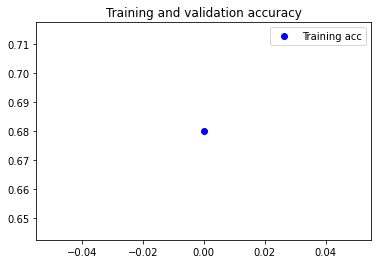

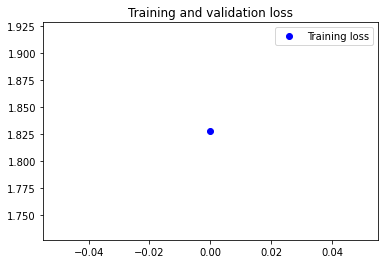

In [19]:
acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
# plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
# plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine Tuning EfficientNet



In [20]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST // batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

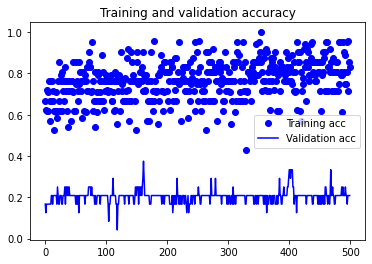

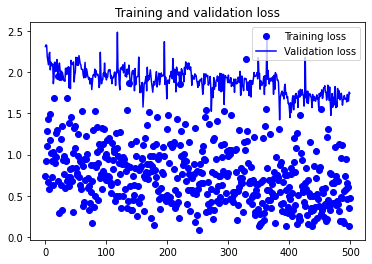

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Save EfficientNet Model Weights

In [ ]:
os.makedirs("./models", exist_ok=True)
model.save('./models/efficientNet.h5')

# Use EfficientNet Trained Model for Inference



In [ ]:
import random
test_dir = '/content/efficientnet_keras_transfer_learning/test/'
test_imgs = []
for path, subdirs, files in os.walk(test_dir):
    for name in files:
        test_imgs.append(os.path.join(path, name))
random_test_image = random.choice(test_imgs)
random_test_image

'/content/efficientnet_keras_transfer_learning/test/scissors/scissors8_png.rf.f99916b8f1d31435a5e8ec835fc05119.jpg'

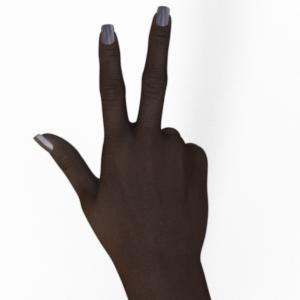

In [ ]:
Image(filename=random_test_image)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

#recover class names from the train dataset generator
class_lookup = dict((y,x) for x,y in train_generator.class_indices.items())

def predict_image(img_path, class_lookup):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    result_verbose = model.predict([x])
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    print(result_verbose)
    predicted_class = class_lookup[np.argmax(result_verbose, axis=1)[0]]
    predicted_probability = result_verbose[0][np.argmax(result_verbose, axis=1)[0]]

    return predicted_class ,predicted_probability, result_verbose

print(predict_image(random_test_image, class_lookup))

[[0.02525645 0.08585829 0.8888853 ]]
('scissors', 0.8888853, array([[0.02525645, 0.08585829, 0.8888853 ]], dtype=float32))


## Download Trained EfficientNet Model

In [ ]:
from google.colab import files

files.download('./models/efficientNet.h5')

In [ ]:
model.input_shape

(None, 150, 150, 3)

## Load Trained EfficientNet Model

In [ ]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("./models/efficientNet.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
